# A Basic Weather Model made using XGBoost

A simple weather model using XGBoost.

In [131]:
import sys
!{sys.executable} -m pip install xgboost
!pip install shap


In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

weather = pd.read_csv("Merged_DataSets.csv",index_col=1, encoding='latin1' )
weather.head(10)

,name,humidity,precip,windspeed,cloudcover,visibility,tempmax c,tempmin c,avgtemp c,feelslikemax c,feelslikemin c,avgfeelsliketemp c,dewpoint c,precip_chance
datetime,,,,,,,,,,,,,,
2005-01-01,Arima,92.8,33.6296,10.3,87.1,6.4,29.0,24.1,25.4,34.6,24.1,26.2,24.1,1
2005-01-02,Arima,78.9,6.1722,13.8,64.6,7.8,32.0,23.1,26.6,34.2,23.1,27.5,22.1,1
2005-01-03,Arima,81.5,0.4826,8.1,54.8,8.4,31.8,22.1,25.5,34.0,22.1,26.4,21.8,1
2005-01-04,Arima,93.2,12.1666,11.4,83.1,6.8,29.2,23.1,24.6,33.7,23.1,25.1,23.3,1
2005-01-05,Arima,83.2,0.7874,4.7,77.9,16.8,31.3,23.7,25.1,33.4,23.7,25.3,21.8,1
2005-01-06,Arima,83.2,2.1590,10.3,92.5,9.8,30.2,24.6,26.6,34.7,24.6,27.7,23.3,1
2005-01-07,Arima,90.5,10.7950,16.1,95.0,4.4,27.1,23.1,24.9,30.4,23.1,25.7,23.2,1
2005-01-08,Arima,81.3,8.8138,10.3,90.0,10.0,29.2,24.1,26.4,32.7,24.1,28.0,22.7,1
2005-01-09,Arima,78.5,0.0000,12.8,81.6,9.5,30.1,23.7,27.3,34.2,23.7,29.5,23.1,0


In [133]:
weather.apply(pd.isnull).sum()

name                  0
humidity              0
precip                0
windspeed             0
cloudcover            0
visibility            0
tempmax c             0
tempmin c             0
avgtemp c             0
feelslikemax c        0
feelslikemin c        0
avgfeelsliketemp c    0
dewpoint c            0
precip_chance         0
dtype: int64

In [134]:
weather.dtypes

name                   object
humidity              float64
precip                float64
windspeed             float64
cloudcover            float64
visibility            float64
tempmax c             float64
tempmin c             float64
avgtemp c             float64
feelslikemax c        float64
feelslikemin c        float64
avgfeelsliketemp c    float64
dewpoint c            float64
precip_chance           int64
dtype: object

In [135]:
weather.index

Index(['2005-01-01', '2005-01-02', '2005-01-03', '2005-01-04', '2005-01-05',
       '2005-01-06', '2005-01-07', '2005-01-08', '2005-01-09', '2005-01-10',
       ...
       '2025-04-28', '2025-04-28', '2025-04-28', '2025-04-28', '2025-04-28',
       '2025-04-28', '2025-04-28', '2025-04-28', '2025-04-28', '2025-04-28'],
      dtype='object', name='datetime', length=122008)

In [136]:
weather.index = pd.to_datetime(weather.index)
weather.index

DatetimeIndex(['2005-01-01', '2005-01-02', '2005-01-03', '2005-01-04',
               '2005-01-05', '2005-01-06', '2005-01-07', '2005-01-08',
               '2005-01-09', '2005-01-10',
               ...
               '2025-04-28', '2025-04-28', '2025-04-28', '2025-04-28',
               '2025-04-28', '2025-04-28', '2025-04-28', '2025-04-28',
               '2025-04-28', '2025-04-28'],
              dtype='datetime64[ns]', name='datetime', length=122008, freq=None)

<Axes: xlabel='datetime'>

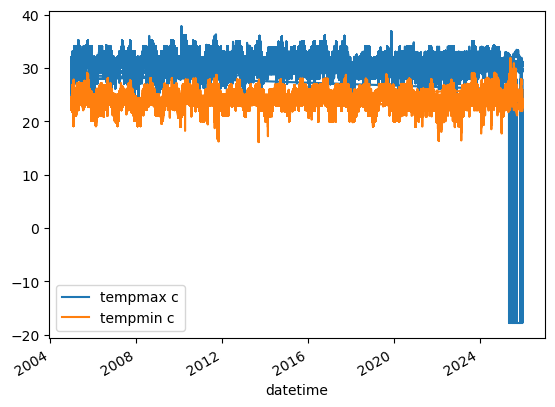

In [137]:
weather[["tempmax c", "tempmin c"]].plot()

# Train Test Split

In [139]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
weather['location_encoded'] = le.fit_transform(weather['name'])

weather.columns

Index(['name', 'humidity', 'precip', 'windspeed', 'cloudcover', 'visibility',
       'tempmax c', 'tempmin c', 'avgtemp c', 'feelslikemax c',
       'feelslikemin c', 'avgfeelsliketemp c', 'dewpoint c', 'precip_chance',
       'location_encoded'],
      dtype='object')

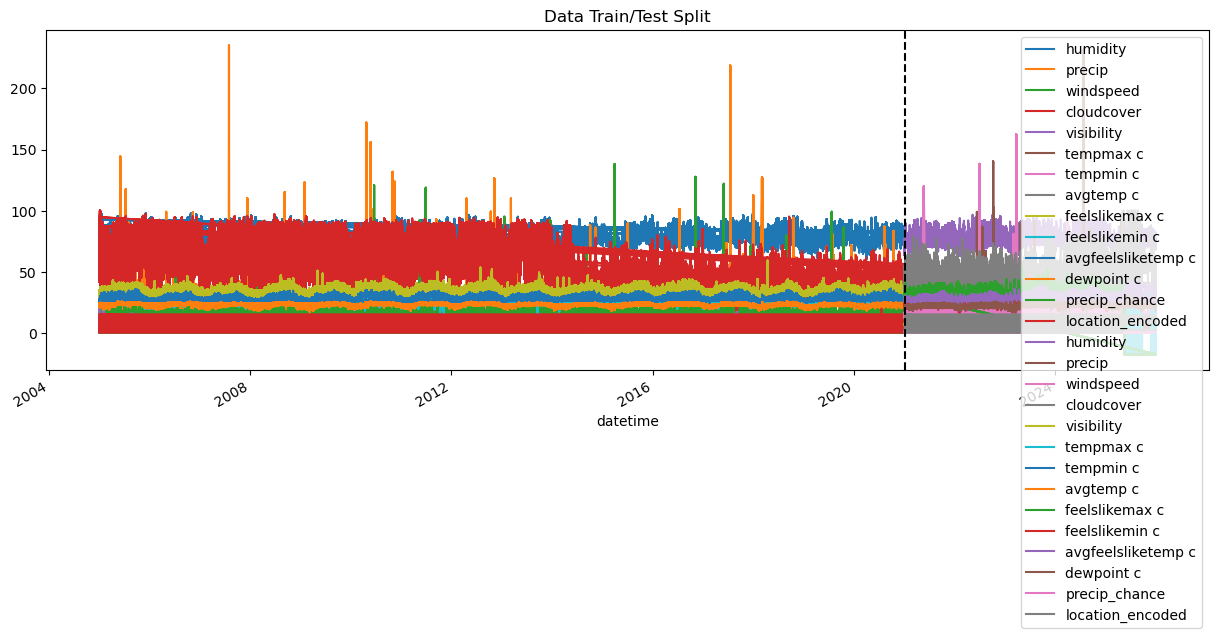

In [140]:
train = weather.loc[weather.index < '01-01-2021']
test = weather.loc[weather.index > '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
plt.show()

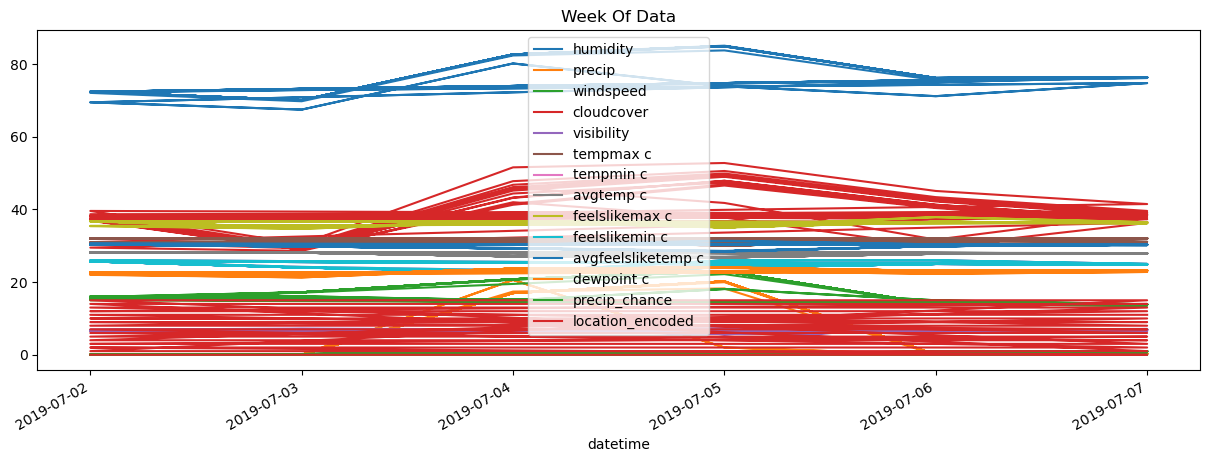

In [141]:
weather.loc[(weather.index > '07-01-2019') & (weather.index < '07-08-2019')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Create features 

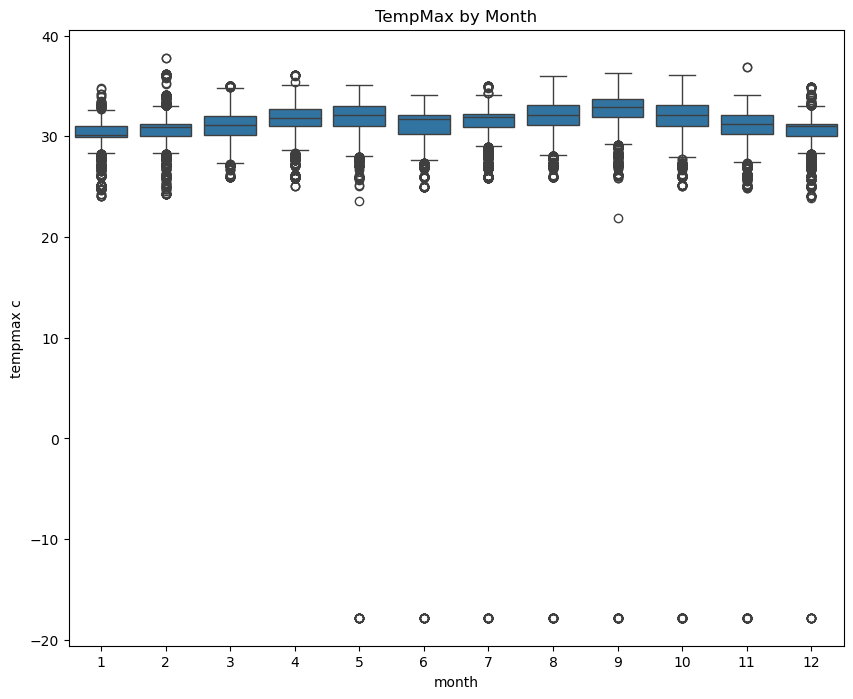

In [143]:
df = weather.copy()
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='tempmax c')
ax.set_title('TempMax by Month')
plt.show()

Index(['name', 'humidity', 'precip', 'windspeed', 'cloudcover', 'visibility',
       'tempmax c', 'tempmin c', 'avgtemp c', 'feelslikemax c',
       'feelslikemin c', 'avgfeelsliketemp c', 'dewpoint c', 'precip_chance',
       'location_encoded'],
      dtype='object')


<bound method Axes.set_title of <Axes: xlabel='month', ylabel='tempmin c'>>

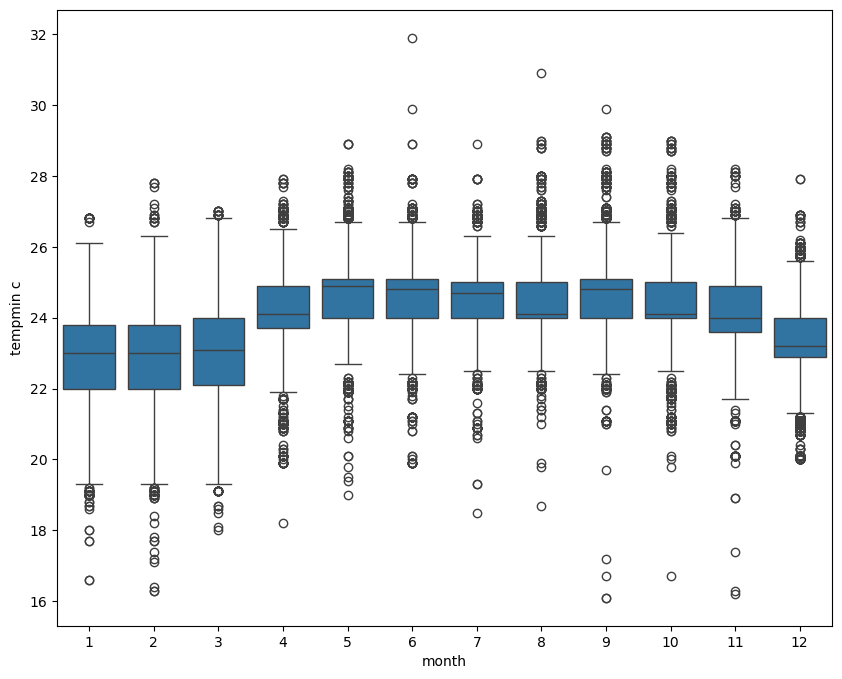

In [144]:
print(weather.columns)
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    return df
df = create_features(weather)

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='tempmin c')
ax.set_title

In [145]:
df.head(10)

,name,humidity,precip,windspeed,cloudcover,visibility,tempmax c,tempmin c,avgtemp c,feelslikemax c,feelslikemin c,avgfeelsliketemp c,dewpoint c,precip_chance,location_encoded,dayofweek,dayofyear,month,year
datetime,,,,,,,,,,,,,,,,,,,
2005-01-01,Arima,92.8,33.6296,10.3,87.1,6.4,29.0,24.1,25.4,34.6,24.1,26.2,24.1,1,0,5,1,1,2005
2005-01-02,Arima,78.9,6.1722,13.8,64.6,7.8,32.0,23.1,26.6,34.2,23.1,27.5,22.1,1,0,6,2,1,2005
2005-01-03,Arima,81.5,0.4826,8.1,54.8,8.4,31.8,22.1,25.5,34.0,22.1,26.4,21.8,1,0,0,3,1,2005
2005-01-04,Arima,93.2,12.1666,11.4,83.1,6.8,29.2,23.1,24.6,33.7,23.1,25.1,23.3,1,0,1,4,1,2005
2005-01-05,Arima,83.2,0.7874,4.7,77.9,16.8,31.3,23.7,25.1,33.4,23.7,25.3,21.8,1,0,2,5,1,2005
2005-01-06,Arima,83.2,2.1590,10.3,92.5,9.8,30.2,24.6,26.6,34.7,24.6,27.7,23.3,1,0,3,6,1,2005
2005-01-07,Arima,90.5,10.7950,16.1,95.0,4.4,27.1,23.1,24.9,30.4,23.1,25.7,23.2,1,0,4,7,1,2005
2005-01-08,Arima,81.3,8.8138,10.3,90.0,10.0,29.2,24.1,26.4,32.7,24.1,28.0,22.7,1,0,5,8,1,2005
2005-01-09,Arima,78.5,0.0000,12.8,81.6,9.5,30.1,23.7,27.3,34.2,23.7,29.5,23.1,0,0,6,9,1,2005


# Model 


In [147]:
train = create_features(train)
test = create_features(test)

target = ['tempmax c', 'tempmin c', 'avgtemp c', 'feelslikemax c','feelslikemin c','avgfeelsliketemp c', 'dewpoint c','humidity','windspeed','cloudcover','visibility', 'precip']
features = ['location_encoded','dayofweek','dayofyear','month','year', 'tempmax c', 'tempmin c', 'avgtemp c', 'feelslikemax c','feelslikemin c','avgfeelsliketemp c', 'dewpoint c','humidity','windspeed','cloudcover','visibility', 'precip']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [148]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=5,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

y_train = train[target]

X_test = test[features]
y_test = test[target]

[0]	validation_0-rmse:35.70438	validation_1-rmse:33.96742
[100]	validation_0-rmse:13.09275	validation_1-rmse:12.69776
[200]	validation_0-rmse:4.82390	validation_1-rmse:5.37763
[300]	validation_0-rmse:1.82490	validation_1-rmse:3.34086
[400]	validation_0-rmse:0.79157	validation_1-rmse:2.96230
[500]	validation_0-rmse:0.49665	validation_1-rmse:2.90624
[600]	validation_0-rmse:0.42205	validation_1-rmse:2.89434
[665]	validation_0-rmse:0.40119	validation_1-rmse:2.89212


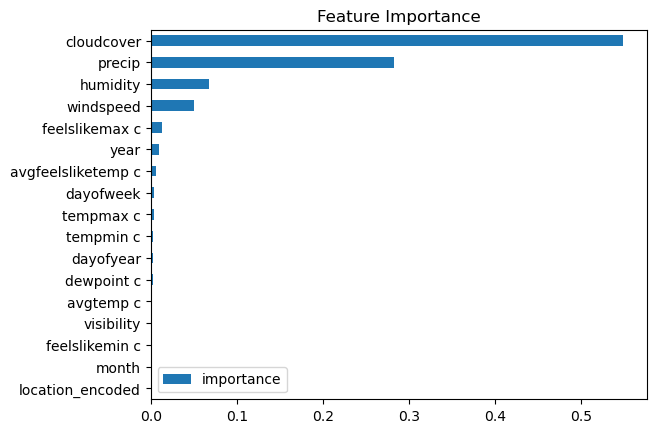

In [149]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [150]:
ptest = model.predict(X_test)
ptest

array([[2.9962385e+01, 2.2971201e+01, 2.5667755e+01, ..., 5.2636040e+01,
        6.3927498e+00, 2.7092850e+00],
       [2.9962385e+01, 2.0975531e+01, 2.5667755e+01, ..., 3.4112782e+01,
        7.1911249e+00, 3.0778211e-02],
       [3.0761225e+01, 2.0876223e+01, 2.4969610e+01, ..., 2.9545540e+01,
        7.0913386e+00, 3.0778211e-02],
       ...,
       [3.1060392e+01, 2.4768837e+01, 2.7764769e+01, ..., 4.8092655e+01,
        7.6902146e+00, 3.0778211e-02],
       [3.1060392e+01, 2.4768837e+01, 2.7764769e+01, ..., 4.8092655e+01,
        7.6902146e+00, 3.0778211e-02],
       [3.1060392e+01, 2.4768837e+01, 2.7764769e+01, ..., 4.8092655e+01,
        7.6902146e+00, 3.0778211e-02]], dtype=float32)

In [151]:
# Evaluating the XGBoost model on the testing set

from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(mae)
print(rmse)

0.24109683668272477
2.892071247939381


In [152]:
columns = df.columns

# Add each prediction as a new column in test
for i, col in enumerate(y_test.columns):
    test[f"{col}_prediction"] = ptest[:, i]
print(test.filter(like='_prediction').head(1))

            tempmax c_prediction  tempmin c_prediction  avgtemp c_prediction  \
datetime                                                                       
2021-01-02             29.962385             22.971201             25.667755   

            feelslikemax c_prediction  feelslikemin c_prediction  \
datetime                                                           
2021-01-02                  31.861849                  22.971405   

            avgfeelsliketemp c_prediction  dewpoint c_prediction  \
datetime                                                           
2021-01-02                      26.267666              21.073685   

            humidity_prediction  windspeed_prediction  cloudcover_prediction  \
datetime                                                                       
2021-01-02            76.700981                14.891               52.63604   

            visibility_prediction  precip_prediction  
datetime                                             

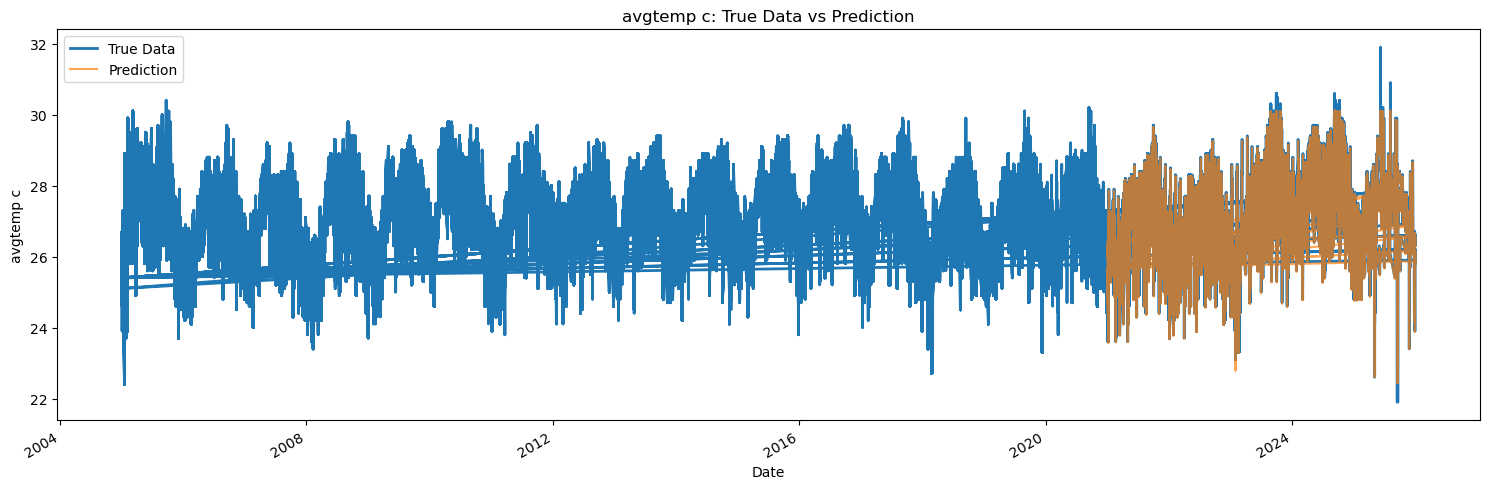

In [153]:
fig, ax = plt.subplots(figsize=(15, 5))

category = 'avgtemp c'

# Plot actual data from df
df[category].plot(ax=ax, label='True Data', linewidth=2)

# Plot predictions from test
test[f"{category}_prediction"].plot(ax=ax, label='Prediction', alpha=0.7)

ax.set_title(f"{category}: True Data vs Prediction")
ax.set_xlabel("Date")
ax.set_ylabel(category)
ax.legend()

plt.tight_layout()
plt.show()

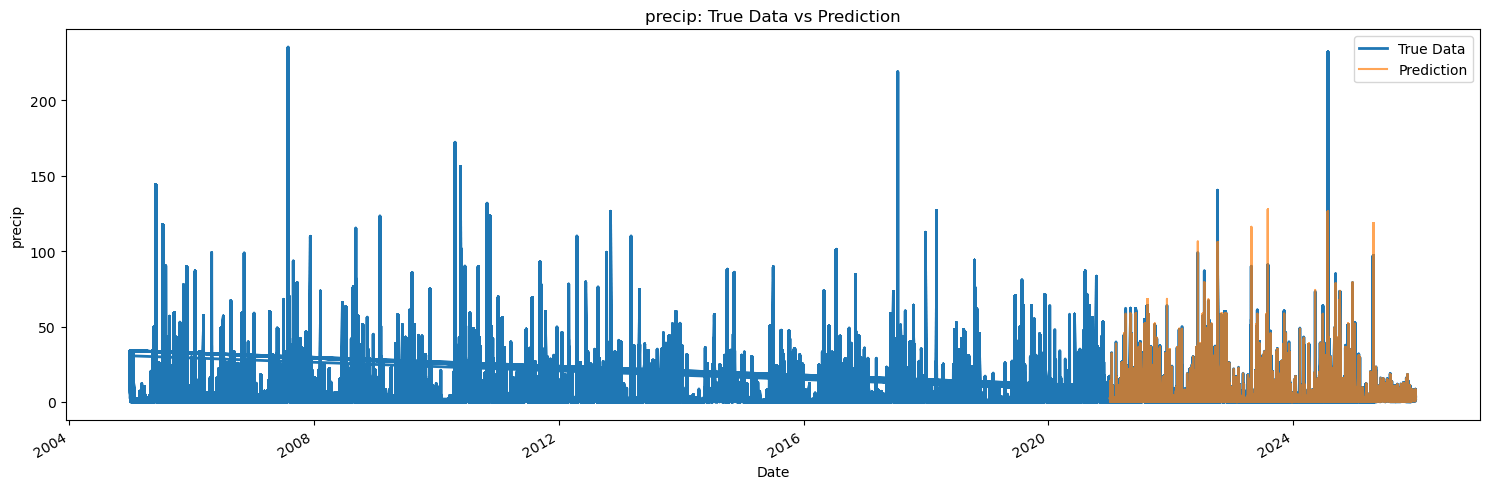

In [154]:
fig, ax = plt.subplots(figsize=(15, 5))

category = 'precip'

# Plot actual data from df
df[category].plot(ax=ax, label='True Data', linewidth=2)

# Plot predictions from test
test[f"{category}_prediction"].plot(ax=ax, label='Prediction', alpha=0.7)

ax.set_title(f"{category}: True Data vs Prediction")
ax.set_xlabel("Date")
ax.set_ylabel(category)
ax.legend()

plt.tight_layout()
plt.show()

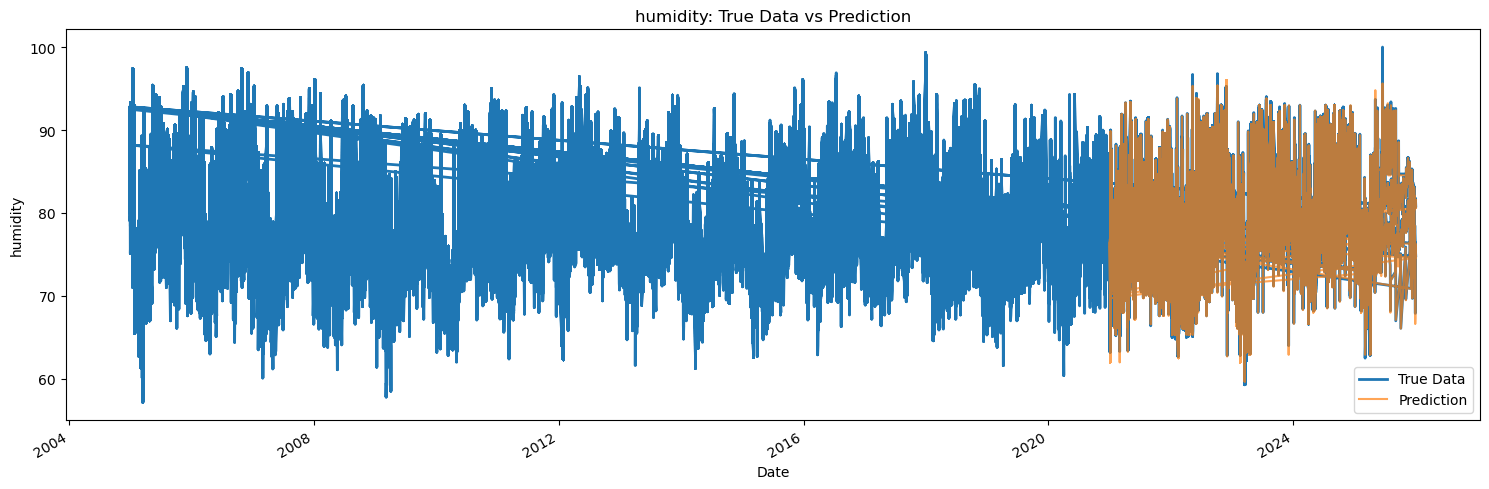

In [155]:
fig, ax = plt.subplots(figsize=(15, 5))

category = 'humidity'

# Plot actual data from df
df[category].plot(ax=ax, label='True Data', linewidth=2)

# Plot predictions from test
test[f"{category}_prediction"].plot(ax=ax, label='Prediction', alpha=0.7)

ax.set_title(f"{category}: True Data vs Prediction")
ax.set_xlabel("Date")
ax.set_ylabel(category)
ax.legend()

plt.tight_layout()
plt.show()

In [156]:
import joblib

joblib.dump(model, 'xgb_model.pkl')


['xgb_model.pkl']